In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import sem
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import MultiComparison
from typing import Tuple

from behav_analysis import Participant_Behav, Behav_Results
from data_functions import load_results


ImportError: cannot import name 'Behav_Results' from 'behav_analysis' (c:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\behav_analysis.py)

In [213]:
class Behav_Results:
    """
    This class contains attributes and functions for deriving and
    plotting statistical results from processed behavioral data.
    """

    def __init__(self):
        self.dark_blue = (12 / 255, 37 / 255, 72 / 255)
        self.bar_width = 0.6
        self.capsize = 4
        self.label_fontsize = 16
        self.tick_fontsize = 14
        self.font = "Arial"
        self.par = Participant_Behav(1)

    def process_king_devick_df(self, behav_data: pd.DataFrame) -> pd.DataFrame:  # TODO
        behav_data = behav_data.drop(
            behav_data[
                (behav_data["participant"] == 15) & (behav_data["trial"] == 1)
            ].index
        )
        behav_data.loc[behav_data["participant"] == 15, ["trial"]] -= 1
        behav_data.loc[behav_data["participant"] == 15, "block"] = behav_data.loc[
            behav_data["participant"] == 15, "block"
        ].apply(lambda x: x[:-1] + str(int(x[-1]) - 1))
        return behav_data

    def run_stats(self, exp_name: str) -> None:
        """
        Run a statistical test (t-test or ANOVA) to determine significant
        task condition differences for an experiment.

        Args:
            exp_name (str): Experiment name.
        """
        exp_results = load_results(self.par.processed_data_dir, exp_name)

        if exp_name == "king_devick":
            conditions = ["response_time", "num_incorrect"]
            exp_results = self.process_king_devick_df(exp_results)
        elif (
            exp_name == "go_no_go"
            or exp_name == "n_back"
            or exp_name == "tower_of_london"
            or exp_name == "vSAT"
        ):
            conditions = ["correct_response", "response_time"]

        blocks = list(exp_results["block"].unique())
        if len(blocks) > 2:
            stat_test = "ANOVA"
        else:
            stat_test = "t-test"

        conditions_dict = {}
        for condition in conditions:
            condition_results = exp_results.copy()
            condition_results = condition_results.dropna(subset=[condition])
            block_list = []
            for block in blocks:
                block_condition_row = condition_results[
                    condition_results["block"] == block
                ][condition]
                block_list.append(block_condition_row)
            conditions_dict[condition] = block_list

            if condition == "correct_response":
                condition_name_fmt = "Response Accuracy"
            else:
                condition_name_fmt = condition.replace("_", " ").title()
            if stat_test == "ANOVA":
                if exp_name == "n_back":
                    print(
                        f"----- {exp_name.replace('_', '-').title()} {condition_name_fmt} t-test -----"
                    )
                elif exp_name == "king_devick" and condition == "num_incorrect":
                    print(
                        f"----- {exp_name.replace('_', '-').title()} {condition_name_fmt} t-test -----"
                    )
                else:
                    print(
                        f"----- {exp_name.replace('_', ' ').title()} {condition_name_fmt} ANOVA -----"
                    )
                condition_rows = conditions_dict[condition]
                # run one-way ANOVA
                f_stat, p_value = f_oneway(*condition_rows)
                # run Tukey HSD post hoc test
                mc = MultiComparison(
                    condition_results[condition], condition_results["block"]
                )
                result = mc.tukeyhsd()
                print("F-statistic:", round(f_stat, 4))
                print("P-value:", round(p_value, 4))
                print("")
                print(result)
                print("\n")
            elif stat_test == "t-test":
                condition_rows = conditions_dict[condition]
                # run t-test
                t_stat, p_value = ttest_ind(*condition_rows)
                if condition == "correct_response":
                    condition_name_fmt = "Response Accuracy"
                else:
                    condition_name_fmt = condition.replace("_", " ").title()
                if exp_name == "tower_of_london":
                    print(f"----- Tower of London {condition_name_fmt} t-test -----")
                else:
                    print(
                        f"----- {exp_name.replace('_', ' ').title()} {condition_name_fmt} t-test -----"
                    )
                print("T-statistic:", round(t_stat, 4))
                print("P-value:", round(p_value, 4))
                print("\n")

    def get_bar_plot_data(self, exp_name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Group experiment data and calculate the mean response time and response accuracy.

        Args:
            exp_name (str): Experiment name.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Bar plot block data and SEM data.
        """
        behav_data = load_results(self.par.processed_data_dir, exp_name)

        if exp_name == "king_devick":
            self.group_var = "num_incorrect"
            self.group_label = "Mean incorrect responses"
            behav_data = self.process_king_devick_df(behav_data)

            block_data = behav_data.groupby("block").mean()[
                ["response_time", "num_incorrect"]
            ]
            block_sem = behav_data.groupby("block").agg(
                lambda x: sem(x, nan_policy="omit")
            )[["response_time", "num_incorrect"]]
            self.xtick_labels = [
                block.replace("_", " ").title() for block in list(block_data.index)
            ]

        elif (
            exp_name == "go_no_go"
            or exp_name == "n_back"
            or exp_name == "tower_of_london"
            or exp_name == "vSAT"
        ):
            self.group_var = "correct_response"
            self.group_label = "Mean response accuracy"
            block_data = behav_data.groupby("block").mean()[
                ["response_time", "correct_response"]
            ]
            block_sem = behav_data.groupby("block").agg(
                lambda x: sem(x, nan_policy="omit")
            )[["response_time", "correct_response"]]
            if exp_name == "tower_of_london":
                self.xtick_labels = ["Multi-move", "Zero-move"]
            elif exp_name == "go_no_go":
                self.xtick_labels = ["Go/no-go", "Go"]
            else:
                self.xtick_labels = [
                    block.replace("_", " ").title() for block in block_data.index
                ]
        return block_data, block_sem

    def create_bar_plot(self, exp_name: str) -> None:
        """
        Create a bar plot for a specified experiment.

        Args:
            exp_name (str): Experiment name.
        """

        def _format_ticks(ticks: list) -> list:
            """
            Format ticks to have 2 decimal places.

            Args:
                ticks (list): List of ticks.

            Returns:
                list: List of formatted ticks.
            """
            return [f"{tick:.2f}" for tick in ticks]

        block_data, block_sem = self.get_bar_plot_data(exp_name)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        fig.subplots_adjust(wspace=-0.5)

        # response accuracy
        ax1.bar(
            np.arange(len(block_data)),
            block_data[self.group_var],
            color=self.dark_blue,
            width=self.bar_width,
            yerr=block_sem[self.group_var],
            capsize=self.capsize,
            zorder=0,
            ecolor=self.dark_blue,
        )
        ax1.set_ylabel(
            self.group_label,
            color="black",
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax1.yaxis.set_label_coords(-0.2, 0.5)
        ax1.tick_params(axis="y", labelcolor="black")
        ax1.set_xticks(np.arange(len(block_data)))
        ax1.set_xticklabels(
            self.xtick_labels,
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax1.spines[["top"]].set_visible(False)

        # response time
        ax2.bar(
            np.arange(len(block_data)),
            block_data["response_time"],
            color=self.dark_blue,
            width=self.bar_width,
            yerr=block_sem["response_time"],
            capsize=self.capsize,
            zorder=0,
            ecolor=self.dark_blue,
        )
        ax2.set_ylabel(
            "Mean response time (sec)",
            color="black",
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax2.yaxis.set_label_coords(-0.2, 0.5)
        ax2.tick_params(axis="y", labelcolor="black")
        ax2.set_xticks(np.arange(len(block_data)))
        ax2.set_xticklabels(
            self.xtick_labels,
            fontsize=self.label_fontsize,
            fontname=self.font,
        )
        ax2.spines[["top"]].set_visible(False)

        # ticks and tick labels
        if exp_name == "go_no_go":
            acc_ylim = [0.9, 1]
            acc_yticks = [0.9, 0.92, 0.94, 0.96, 0.98, 1]
            acc_ytick_labels = [0.9, 0.92, 0.94, 0.96, 0.98, 1]
            resp_ylim = [0.4, 0.54]
            resp_yticks = [0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54]
            resp_ytick_labels = [0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54]
        elif exp_name == "king_devick":
            acc_ylim = [0, 0.4]
            acc_yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
            acc_ytick_labels = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
            resp_ylim = [14, 17]
            resp_yticks = [14, 14.5, 15, 15.5, 16, 16.5, 17]
            resp_ytick_labels = [14, 14.5, 15, 15.5, 16, 16.5, 17]
        elif exp_name == "n_back":
            acc_ylim = [0.7, 1.0]
            acc_yticks = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
            acc_ytick_labels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
            resp_ylim = [0.4, 0.8]
            resp_yticks = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
            resp_ytick_labels = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
        elif exp_name == "tower_of_london":
            acc_ylim = [0.8, 1]
            acc_yticks = [0.8, 0.85, 0.9, 0.95, 1]
            acc_ytick_labels = [0.8, 0.85, 0.9, 0.95, 1]
            resp_ylim = [0.6, 0.9]
            resp_yticks = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
            resp_ytick_labels = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
        elif exp_name == "vSAT":
            acc_ylim = [0.9, 0.94]
            acc_yticks = [0.9, 0.91, 0.92, 0.93, 0.94]
            acc_ytick_labels = [0.9, 0.91, 0.92, 0.93, 0.94]
            resp_ylim = [0.5, 0.58]
            resp_yticks = [0.5, 0.52, 0.54, 0.56, 0.58]
            resp_ytick_labels = [0.5, 0.52, 0.54, 0.56, 0.58]

        ax1.set_ylim(acc_ylim)
        ax2.set_ylim(resp_ylim)

        try:  # if ticks and tick labels are not specified, use defaults
            ax1.set_yticks(acc_yticks)
            ax1.set_yticklabels(
                _format_ticks(acc_ytick_labels),
                fontsize=self.tick_fontsize,
                fontname=self.font,
            )
            ax2.set_yticks(resp_yticks)
            ax2.set_yticklabels(
                _format_ticks(resp_ytick_labels),
                fontsize=self.tick_fontsize,
                fontname=self.font,
            )
        except:
            pass

        plt.tight_layout()
        plt.show()

        self.run_stats(exp_name)


C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\3433867533.py:152: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  block_data = behav_data.groupby("block").mean()[
C:\Users\zackg\AppData\Local\Temp\ipykernel_17148\3433867533.py:155: FutureWarning: ['date', 'time', 'sex', 'native_language', 'educational_history', 'stim'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  block_sem = behav_data.groupby("block").agg(


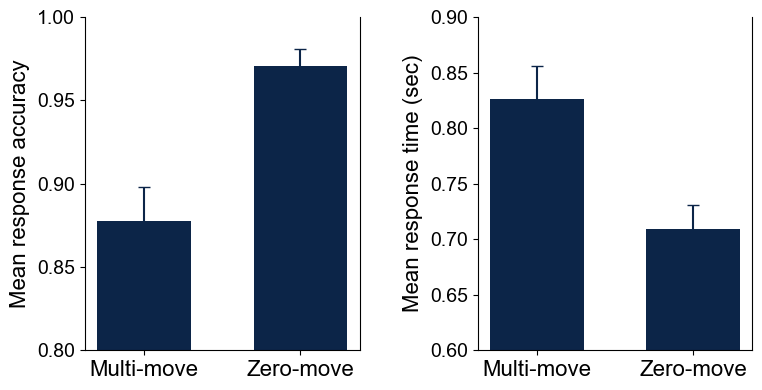

----- Tower of London Response Accuracy t-test -----
T-statistic: -4.1174
P-value: 0.0


----- Tower of London Response Time t-test -----
T-statistic: 3.1674
P-value: 0.0016




In [215]:
par = Participant_Behav(par_num=1)
# exp_name = "n_back"
# exp_name = "king_devick"
# exp_name = "n_back"
exp_name = "tower_of_london"
# exp_name = "vSAT"
BH = Behav_Results()
BH.create_bar_plot(exp_name)